In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
data_dir = '/Users/annagreene/code/district-comparison/data/'
dist1 = pd.read_csv(data_dir + 'raw/arizonaExample.csv')
mapping = pd.read_csv(data_dir + 'raw/final_mapping.csv')
dist2 = pd.read_csv(data_dir + 'raw/atlantaExample.csv')
replace = [',', '$', '-', '(', ')']
pd.options.mode.chained_assignment = None

In [4]:
#everything from clean tolleson script
dist1["Object_code"] = 0
dist1["Object_code"] = dist1.Account.str.split(".").str[3]

dist1 = dist1[dist1['Account Type']=="EXPENDITURE"]
dist1 = dist1.drop(columns=['Active', 'Account', 'Description', 'Account Type', 'Budget Control Group', 'Budget', 'Balance', 'Budget Balance', 'Encumbrance', 'Pre Encumbrance', 'Pending Invoices', 'Uncommitted Balance'])

dist1['YTD Transactions'] = dist1['YTD Transactions'].str.translate({ord(x): '' for x in replace}).astype(float)
dist1 = dist1.groupby(['Object_code'])['YTD Transactions'].sum().reset_index()
dist1 = dist1.rename(columns={'YTD Transactions': 'Transactions'})
dist1 = dist1.round(2)

dist1 = dist1.rename(columns={'Object_code': 'Code'})
dist1['Code'] = dist1['Code'].astype(str)
dist1['Code'] = dist1['Code'].str.strip()
display(dist1)

,Code,Transactions
0,6000,0.00
1,6100,0.00
2,6101,0.00
3,6103,0.00
4,6110,8002.11
...,...,...
181,6890,455508.18
182,6891,0.00
183,6892,0.00
184,6893,0.00


In [5]:
#everything from clean atlanta script
dist2 = dist2[~dist2.DESCRIPTION.str.contains('TOTAL')]
dist2 = dist2.drop(columns=['Unnamed: 1', 'DESCRIPTION'])
dist2 = dist2.rename(columns={'ACCOUNT': 'Code', ' AMOUNT ': 'Transactions'})

dist2['Code'] = dist2['Code'].str[5:8]
dist2['Code'] = dist2['Code'].astype(str)

dist2['Transactions'] = dist2['Transactions'].str.translate({ord(x): '' for x in replace})
dist2['Transactions'] = np.double(dist2['Transactions'])
dist2 = dist2.groupby(['Code'])['Transactions'].sum().reset_index()
dist2 = dist2.round(2)

display(dist2)

,Code,Transactions
0,110,2.254804e+08
1,111,1.446570e+05
2,112,5.384203e+06
3,113,5.684628e+06
4,114,5.072093e+05
...,...,...
95,880,2.814457e+06
96,881,4.291009e+07
97,882,3.109448e+06
98,890,3.051903e+06


In [6]:
#everything from clean mapping script
cols = ["Object_code","Function_code", "Category_Edstruments","Major_Category_Edstruments","Title", "State"]
clean_map = mapping[cols]
clean_map = clean_map.fillna(0)

clean_map["Code"] = ''
clean_map["Code"] = np.where(clean_map["Object_code"] == 0, clean_map["Function_code"], clean_map["Object_code"])
clean_map["Code"] = clean_map["Code"].astype(str)
clean_map["Code"] = clean_map["Code"].str.strip()
#clean_map = clean_map[clean_map["Code"].str.contains('X')==False]
#clean_map["Code"] = clean_map["Code"].astype(str)

display(clean_map)

,Object_code,Function_code,Category_Edstruments,Major_Category_Edstruments,Title,State,Code
0,10,0,Teachers Salaries,Salaries,Regular Teacher,Alabama,10
1,11,0,Teachers Salaries,Salaries,Resource Teacher,Alabama,11
2,12,0,Teachers Salaries,Salaries,Alternative School Teacher,Alabama,12
3,14,0,Teachers Salaries,Salaries,Teacher - Gifted,Alabama,14
4,15,0,Special Education Salaries,Salaries,Teacher - Collaborative Special Education,Alabama,15
...,...,...,...,...,...,...,...
7962,728,0,Miscellaneous,Other Financing Uses,Transfers to Agency Funds,Wyoming,728
7963,729,0,Miscellaneous,Other Financing Uses,Transfers to Any Other Funds,Wyoming,729
7964,730,0,Miscellaneous,Other Financing Uses,Payments to Escrow Agents,Wyoming,730
7965,740,0,Debt Service,Other Financing Uses,Redemption of Principal Other,Wyoming,740


In [9]:
#stuff from map script
mapping = pd.read_csv(data_dir + 'processed/mapping.csv')
dist_1_og = pd.read_csv(data_dir + 'processed/tolleson.csv')
state_1 = 'Arizona'
dist_2_og = pd.read_csv(data_dir + 'processed/atlanta.csv')
state_2 = 'Georgia'

dist_1_map = mapping[mapping['State'] == state_1].reset_index()
dist_1_map = dist_1_map.drop(columns=['index', 'Unnamed: 0', 'Object_code', 'Function_code'])
dist_1_map.loc[len(dist_1_map.index)] = ['Miscellaneous', 'Other Financing Uses', '*Unable to assign to mapping tool*', state_1, 'XXXX']

dist_2_map = mapping[mapping['State'] == state_2].reset_index()
dist_2_map = dist_2_map.drop(columns=['index', 'Unnamed: 0', 'Object_code', 'Function_code'])
dist_2_map.loc[len(dist_2_map.index)] = ['Miscellaneous', 'Other Financing Uses', '*Unable to assign to mapping tool*', state_2, 'XXXX']

dist_1_og['Code'] = dist_1_og['Code'].astype(str)
dist_2_og['Code'] = dist_2_og['Code'].astype(str)

dist_1_merge_diff = dist_1_og.merge(dist_1_map, how='left', on='Code', indicator=True)
dist_1_merge_diff2 = dist_1_merge_diff[dist_1_merge_diff['_merge'] == 'left_only']
dist_1_not_mapped = list(dist_1_merge_diff2['Code'])
dist_1_og['Code'] = np.where(dist_1_og['Code'].isin(dist_1_not_mapped), dist_1_og['Code'] == 'False', dist_1_og['Code'])

dist_2_merge_diff = dist_2_og.merge(dist_2_map, how='left', on='Code', indicator=True)
dist_2_merge_diff2 = dist_2_merge_diff[dist_2_merge_diff['_merge'] == 'left_only']
dist_2_not_mapped = list(dist_2_merge_diff2['Code'])
dist_2_og['Code'] = np.where(dist_2_og['Code'].isin(dist_2_not_mapped), dist_2_og['Code'] == 'False', dist_2_og['Code'])

dist_1_og.loc[(dist_1_og.Code == False),'Code']='XXXX'
dist_1_og = dist_1_og.groupby(['Code'])['Transactions'].sum().reset_index()

dist_2_og.loc[(dist_2_og.Code == False),'Code']='XXXX'
dist_2_og = dist_2_og.groupby(['Code'])['Transactions'].sum().reset_index()

dist_1_merge = dist_1_og.merge(dist_1_map, how='left', on='Code')
dist_1_merge['district'] = 'Tolleson'
dist_1_merge

dist_2_merge = dist_2_og.merge(dist_2_map, how='left', on='Code')
dist_2_merge['district'] = 'Atlanta'
dist_2_merge

,Code,Transactions,Category_Edstruments,Major_Category_Edstruments,Title,State,district
0,110,2.254804e+08,Teachers Salaries,Salaries,TEACHERS,Georgia,Atlanta
1,111,1.446570e+05,Support Staff Salaries,Salaries,SCHOOL BOARD MEMBERS SALARIES,Georgia,Atlanta
2,112,5.384203e+06,Teachers Salaries,Salaries,PREKINDERGARTEN TEACHER,Georgia,Atlanta
3,113,5.684628e+06,Other Salaries,Salaries,SUBSTITUTE/TEMPORARY EMPLOYEE,Georgia,Atlanta
4,114,5.072093e+05,Other Salaries,Salaries,SUBSTITUTE/TEMPORARY EMPLOYEE,Georgia,Atlanta
...,...,...,...,...,...,...,...
101,881,4.291009e+07,Miscellaneous,Other Financing Uses,Schoolwide Schools,Georgia,Atlanta
102,882,3.109448e+06,Miscellaneous,Other Financing Uses,Federal Administrative Consolidation Program,Georgia,Atlanta
103,890,3.051903e+06,Miscellaneous,Other Financing Uses,OTHER EXPENDITURES,Georgia,Atlanta
104,930,2.556686e+08,Miscellaneous,Other Financing Uses,OPERATING TRANSFERS TO OTHER FUNDS,Georgia,Atlanta


In [13]:
#making datasets from make graphics scripts
dist_1_subcategories = dist_1_merge.groupby("Category_Edstruments")['Transactions'].sum().reset_index()
dist_1_majorcategories = dist_1_merge.groupby("Major_Category_Edstruments")['Transactions'].sum().reset_index()
dist_1_majorcategories['Per Pupil'] = dist_1_majorcategories['Transactions']/11956
dist_1_majorcategories = dist_1_majorcategories.sort_values(by = 'Per Pupil', ascending = False )
dist_1_majorcategories['district'] = 'Tolleson'

dist_2_subcategories = dist_2_merge.groupby("Category_Edstruments")['Transactions'].sum().reset_index()
dist_2_majorcategories = dist_2_merge.groupby("Major_Category_Edstruments")['Transactions'].sum().reset_index()
dist_2_majorcategories['Per Pupil'] = dist_2_majorcategories['Transactions']/52000
dist_2_majorcategories = dist_2_majorcategories.sort_values(by = 'Per Pupil', ascending = False )
dist_2_majorcategories['district'] = 'Atlanta'

dists_sub = [dist_1_subcategories, dist_2_subcategories]
subcategories = pd.concat(dists_sub)

dists_major = [dist_1_majorcategories, dist_2_majorcategories]
majorcategories = pd.concat(dists_major)

majorcategories

,Major_Category_Edstruments,Transactions,Per Pupil,district
5,Salaries,6.330271e+07,5294.639174,Tolleson
0,Capital,5.241503e+07,4383.993459,Tolleson
1,Employee Benefits,1.785088e+07,1493.048096,Tolleson
2,Other Financing Uses,1.729747e+07,1446.760606,Tolleson
3,Purchased Professional and Technical Services,7.534611e+06,630.194958,Tolleson
4,Purchased Property Services,4.732554e+06,395.830882,Tolleson
6,Supplies,3.690902e+06,308.707119,Tolleson
5,Salaries,5.030616e+08,9674.260994,Atlanta
2,Other Financing Uses,5.028332e+08,9669.870022,Atlanta
1,Employee Benefits,2.325262e+08,4471.657007,Atlanta


AttributeError: 'AxesSubplot' object has no attribute 'ravel'

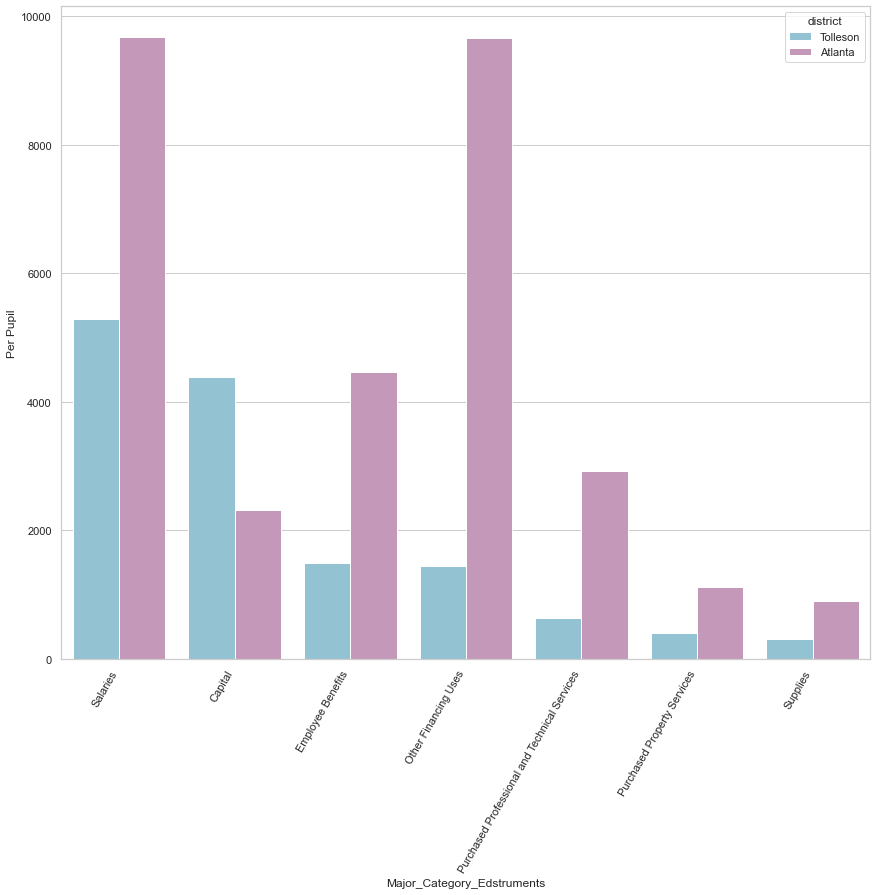

In [78]:
#anna bar graph from make graphics - CATPLOT
sns.set_theme(style="whitegrid")
palette = sns.color_palette(["#89C9DC","#CB91BD"], 2)
plt.figure(figsize=(14.5, 12))

test = sns.catplot(
    data=majorcategories, kind="bar",
    x='Major_Category_Edstruments', y='Per Pupil', hue="district", palette=palette
)

plt.xticks(
    rotation=60, 
    horizontalalignment='right',
)

for ax in test.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), ',.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

#xlabels = ['{:,.0f}'.format(x) for x in labels]
#test.set_xticklabels(xlabels)
test.fig.suptitle('Per-Pupil Expenditure Across Major Categories', fontsize=20, y=1.053)
test.despine(left=True)
test.set_axis_labels("", "Per-Pupil Expenditure")
test.legend.set_title("")
#plt.savefig("BarGraphTEST.png")

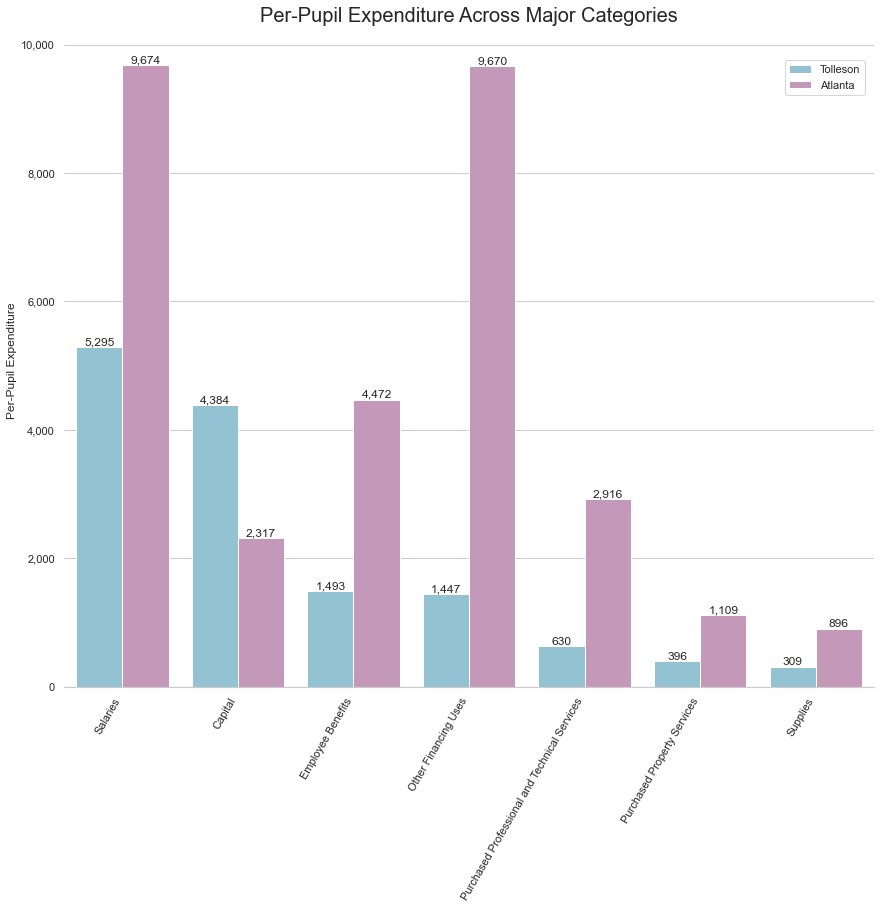

In [113]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette(["#89C9DC","#CB91BD"], 2)
plt.figure(figsize=(14.5, 12))

test = sns.barplot(
    data=majorcategories, x='Major_Category_Edstruments', y='Per Pupil', hue="district", palette=palette
)

plt.xticks(
    rotation=60, 
    horizontalalignment='right',
)

test.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

for p in test.patches:
    test.annotate(format(p.get_height(), ',.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

test.set_title('Per-Pupil Expenditure Across Major Categories', fontsize=20, y=1.01)
sns.despine(left=True)
test.set(xlabel='', ylabel='Per-Pupil Expenditure')
test.legend(bbox_to_anchor=(.89, .96), loc=2, borderaxespad=0.)
#plt.savefig("BarGraphTEST.png")